# Utilização da `BibMon` na detecção de eventos indesejados presentes no `3W Dataset`:

O presente notebook surgiu no `HACKTHON` Petrobras 2024' e demonstra como utilizar o software BibMon para detectar de eventos indesejáveis através de sensores marítimos em poços de petróleo.

> Isso é `EnergIA`! :)

Integrantes:

- Laura Magalhães
- Igor Infingardi
- Juliana Hansen
- Helena Lannes


# Importação e leitura da base de dados

Primeiramente, é necessário importar algumas bibliotecas e funções que serão usadas ao longo da análise:

Dica: Se você está usando o VSCode, só rodar um pip install para as bibliotecas! :)

In [1]:
import sys
import os
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import missingno

sys.path.append('3W')
sys.path.append('BibMon')

A importação dos arquivos será feita, por enquanto, diretamente da pasta do dataset fornecido pelo 3W.

`Aqui será necessário atualizar o PATH de acordo com a localidade do arquivo dataset no seu computador`

Para leitura, utilizaremos a função load_data data abaixo, que lê todos os arquivos dessa pasta, seja em csv ou parquet!

In [2]:
def load_all_data_by_event_and_well(event, well):
    PATH = os.path.join('..', '..', '..', '3W', 'dataset', str(event)) 
    
    # Inicializar a lista de arquivos
    files = []
    
    if os.path.exists(PATH):
        files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]
    else:
        print(f"O caminho {PATH} não existe.")
    
    dfs = {}
    
    if files:  # Verifica se a lista de arquivos não está vazia
        for file in files:
            file_path = os.path.join(PATH, file)
            try:
                fromWell = file.startswith(f"WELL-{well}")
                
                if file.endswith('.csv') and fromWell:
                    # Tentar ler o arquivo CSV com a codificação padrão
                    dfs[file[:-4]] = pd.read_csv(file_path, index_col=0, parse_dates=True).rename_axis(None)
                elif file.endswith('.parquet') and fromWell:
                    # Ler o arquivo Parquet
                    dfs[file[:-8]] = pd.read_parquet(file_path)  # Remover o sufixo '.parquet'
                elif fromWell:
                    print(f"Formato de arquivo desconhecido para {file}.")
            except Exception as e:
                print(f"Erro ao ler {file}: {e}")
    
        print('Data read!\nNumber of instances: ', len(dfs))
    else:
        print("Nenhum arquivo encontrado.")

    return dfs

def load_data_from_file_name(event, fileName):
    PATH = os.path.join('..', '..', '..', '3W', 'dataset', str(event), str(fileName))     

    if os.path.exists(PATH):
        if os.path.isfile(PATH):
            file = PATH
        else:
            print(f"{PATH} não é um diretório.")
    else:
        print(f"O caminho {PATH} não existe.")
    
    dfs = {}
    
    if file.endswith('.csv'):
        # Tentar ler o arquivo CSV com a codificação padrão
        dfs[fileName[:-4]] = pd.read_csv(PATH, index_col=0, parse_dates=True).rename_axis(None)
    elif file.endswith('.parquet'):
        # Ler o arquivo Parquet
        dfs[fileName[:-8]] = pd.read_parquet(PATH)  # Remover o sufixo '.parquet'
    else:
        print(f"Formato de arquivo desconhecido para {file}.")

    return dfs

WELL = '00001'
dataNormalOperation = load_all_data_by_event_and_well(0, WELL)
dataFault = load_data_from_file_name(1, 'WELL-00001_20140124083303.parquet')


Data read!
Number of instances:  93


No dataset há diversos dados, a função getWellDataAndPlot separa todos os arquivos referentes aos poços (well - objeto de estudo) e lê o poço escolhido através do parâmetro well.

No banco de dados há muitas variáveis com valores vazios ou zerados, caso todos estejam nesse formato, a coluna será filtrada pois uma vez que se mantém sempre constante não agregará na nossa análise.

Algumas variáveis não são nulas o tempo inteiro, alternam entre NaN, 0 e vazio e optamos por filtrá-las manualmente por enquanto através da análise exploratório do banco de dados.

A função também plota subgráficos para cada variável, buscando justamente facilitar essa análise descrita acima.

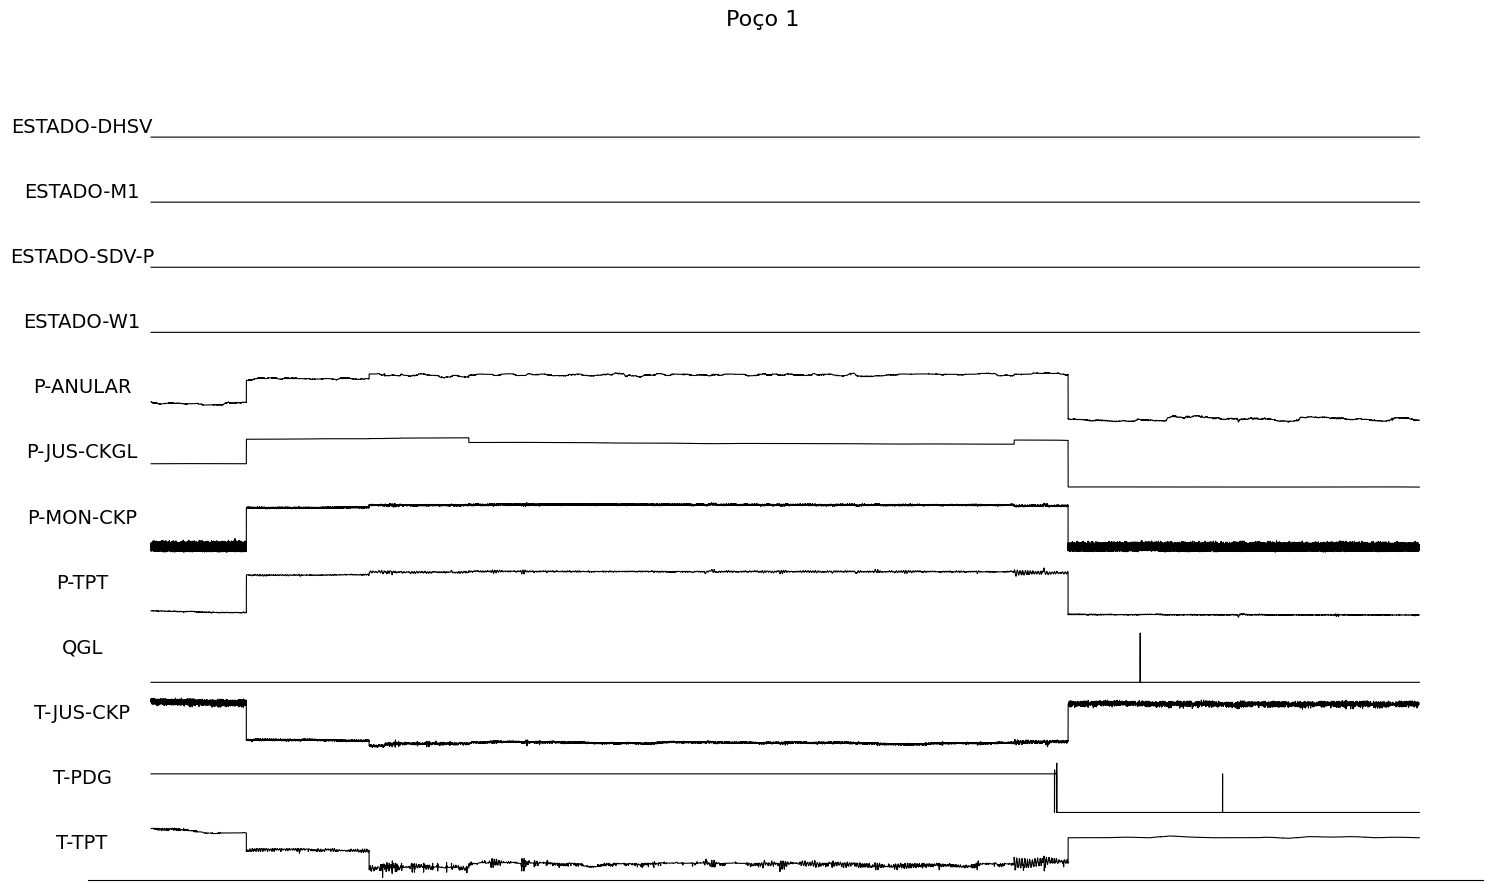

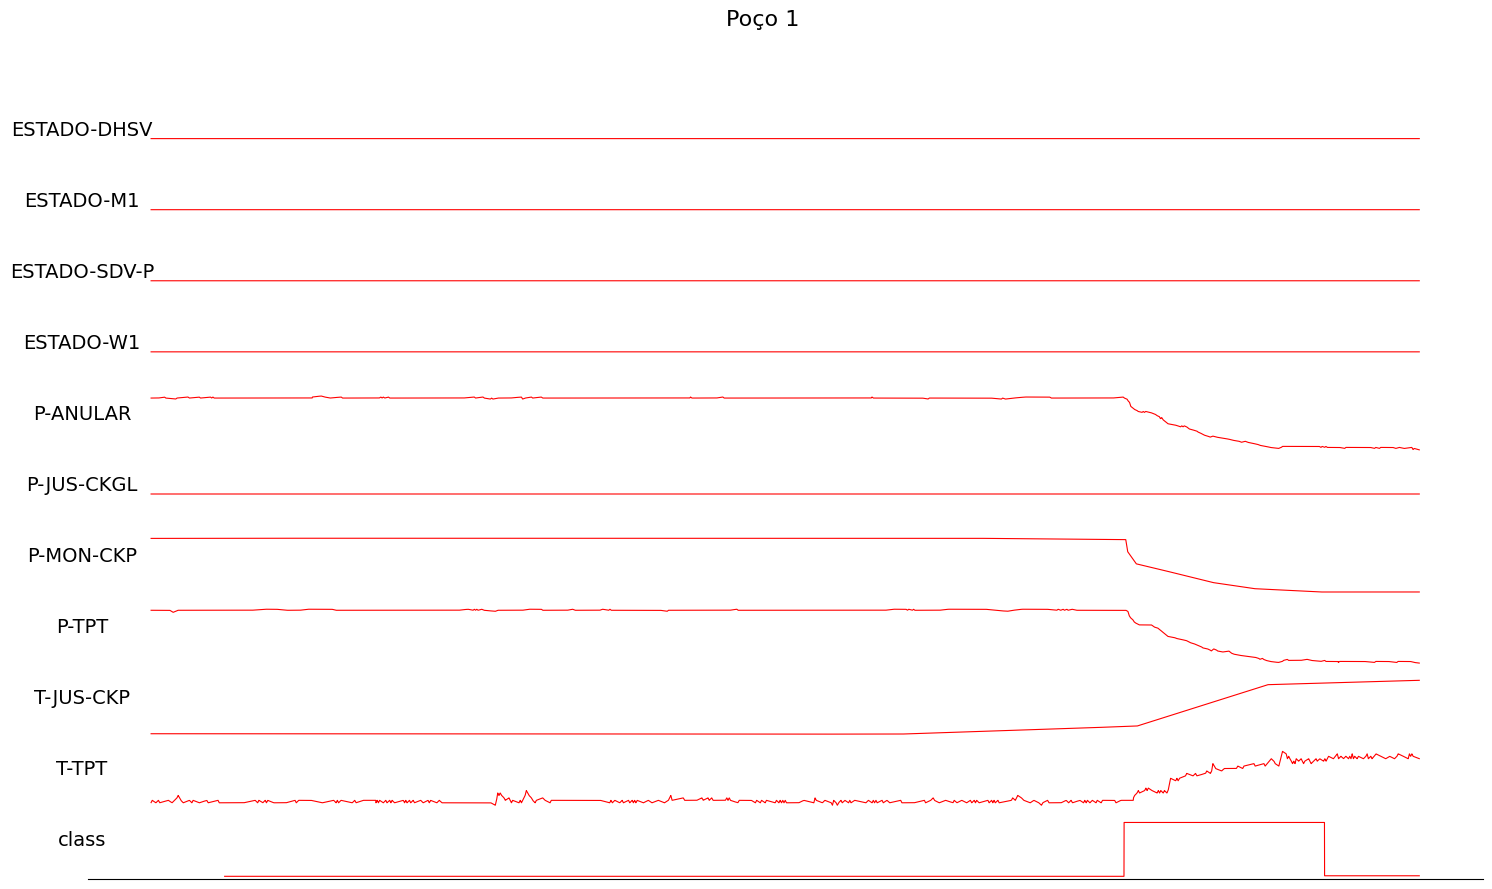

In [3]:
def getWellDataAndPlot(data, color):
    archivesKeys = data.keys()
    filteredByWellData = pd.concat([data[key] for key in archivesKeys]) #Data filtrada para o poço
    
    filteredByWellData = filteredByWellData.apply(pd.to_numeric, errors='coerce')
    # Remover colunas que são todas NaN ou que contêm apenas zeros
    filteredByWellData = filteredByWellData.dropna(axis=1, how='all')  # Remove colunas que são todas NaN
    filteredByWellData = filteredByWellData.loc[:, (filteredByWellData != 0).any(axis=0)]  # Remove colunas que são todas 0
    
    tags = list(filteredByWellData.keys())
    tags = [item for item in tags if item != 'P-PDG']

    fig, ax = plt.subplots(len(tags), 1, figsize=(18, 10),sharex=True)
    fig.suptitle(f"Poço {well}", fontsize=16)
    
    for i, tag in enumerate(tags):
        tagData = filteredByWellData[tag].values
        # print(tagData)
        ax[i].plot(tagData, c=color, linewidth=0.8)
        ax[i].set_ylabel(tag, rotation=0, fontsize=14)
        ax[i].set_yticks([])
    
        # Limpar bordas desnecessárias
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
    
        if i < len(tags)-1:  # Oculta os eixos X de todos, exceto o último gráfico
            ax[i].set_xticks([])
            ax[i].spines["bottom"].set_visible(False)
            ax[i].xaxis.set_ticks_position('none')
        else:
            # Rotaciona rótulos no último gráfico para melhor legibilidade
            for label in ax[i].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')
    return filteredByWellData , tags
   
well = 1

dataNormalOperation, tags0 = getWellDataAndPlot(dataNormalOperation, 'k')    
dataFault, tags1 = getWellDataAndPlot(dataFault, 'r')   

Acima em preto está o comportamento normal de operação e em vermelho está a operação com falha.
A variável class é a chave da determinação da falha, ela indica quando a variável entra no regime transitório de operação (pós-evento não esperado). quando ela está maior que 100, e quando está permanente pós falta, com class mais baixa mas diferente de 0. Em sua operação normal essa variável é 0.

Abaixo há a ordenação das datas. O print está sendo utilizado para verificarmos como essa data está.

In [7]:
dataNormalOperation.index = pd.to_datetime(dataNormalOperation.index)
dataNormalOperation = dataNormalOperation.sort_index()
dataFault.index = pd.to_datetime(dataFault.index)
dataFault = dataFault.sort_index()

                     ESTADO-DHSV  ESTADO-M1  ESTADO-SDV-P  ESTADO-W1  \
timestamp                                                              
2017-02-01 01:02:07          1.0        1.0           1.0        1.0   
2017-02-01 01:02:08          1.0        1.0           1.0        1.0   
2017-02-01 01:02:09          1.0        1.0           1.0        1.0   
2017-02-01 01:02:10          1.0        1.0           1.0        1.0   
2017-02-01 01:02:11          1.0        1.0           1.0        1.0   
...                          ...        ...           ...        ...   
2017-08-28 14:56:13          1.0        1.0           1.0        1.0   
2017-08-28 14:56:14          1.0        1.0           1.0        1.0   
2017-08-28 14:56:15          1.0        1.0           1.0        1.0   
2017-08-28 14:56:16          1.0        1.0           1.0        1.0   
2017-08-28 14:56:17          1.0        1.0           1.0        1.0   

                       P-ANULAR  P-JUS-CKGL  P-MON-CKP      P-P

Como descrevemos acima, a variável class será utilizada para determinar os regimes de operação do sistemas e detecção de evento anormal.
Assim, encontraremos o início desse evento (quando class > 100) e seu fim, novo estado permanente pós falta.

In [5]:
index_above_100 = dataFault[dataFault['class'] > 100].index[0]

# Agora, filtra a partir desse índice para encontrar o primeiro valor onde class < 100
first_below_100_after = dataFault.loc[index_above_100:][dataFault['class'] == 0]

fault_start = index_above_100

if not first_below_100_after.empty:
    fault_end = first_below_100_after.index[0]
else:
    fault_end = dataFault.index[-1]  # Último valor de dataFault


# Mostra os resultados
print("Primeiro índice onde class > 100:", fault_start)
print("Primeiro índice onde class < 100 após esse valor:", fault_end)


Primeiro índice onde class > 100: 2014-01-24 21:46:39
Primeiro índice onde class < 100 após esse valor: 2014-01-25 01:47:30


C:\Users\igori\AppData\Local\Temp\ipykernel_10632\1201678520.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  first_below_100_after = dataFault.loc[index_above_100:][dataFault['class'] == 0]


## Modelagem e detecção das faltas

Para utilizar a `BibMon`, dividiremos nossa base de dados em treinamento, validação e teste. O treinamento gerará nosso modelo e a validação avaliará o modelo e rearranjar o limite de confiança para evitar overfitting, que ocorre quando o modelo está considerando ruídos e outras características que não são sempre constantes e normais.
No teste podemos verificar se o modelo consegue prever a operação normal ou prever uma falta, caso ela aconteça nesse período.
